## Imports

In [1]:
import random
import time
import os, json
import pandas as pd
from collections import defaultdict
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn

## Step0: Simulator ##

In [22]:

# ---------------------- Configuration ----------------------
PROTOCOLS = [
    "MQTT:PUBLISH", "MQTT:SUBSCRIBE", "MQTT:UNSUBSCRIBE",
    "libp2p:GRAFT", "libp2p:PRUNE", "libp2p:IHAVE", "libp2p:IWANT",
    "devp2p:GetBlockHeaders", "devp2p:Transactions", "devp2p:NewBlock",
    "discovery:Ping", "discovery:Pong", "discovery:FindNode", "discovery:Neighbors",
    "ENR:Request", "ENR:Response"
]

LOG_FILE = "network_logs.jsonl"

# ---------------------- Node Class ----------------------
class Node:
    def __init__(self, node_id, is_sybil=False):
        self.node_id = node_id
        self.is_sybil = is_sybil
        self.behavior_type = random.choice(["spammer", "evasive", "flooder"]) if is_sybil else "normal"

    def send_message(self, network, forced_target=None):
        target = forced_target or network.random_node(exclude=self.node_id)
        if not target:
            return

        if self.is_sybil:
            if self.behavior_type == "spammer":
                protocol = random.choice(["MQTT:PUBLISH", "MQTT:PUBLISH", "MQTT:PUBLISH"])
            elif self.behavior_type == "evasive":
                protocol = random.choice(["ENR:Request", "libp2p:PRUNE"])
            else:  # flooder
                protocol = random.choice(["discovery:Ping", "discovery:FindNode"])
        else:
            protocol = random.choice(PROTOCOLS)

        msg = {
            "from": self.node_id,
            "to": target.node_id,
            "protocol": protocol,
            "timestamp": time.time(),
            "is_sybil": self.is_sybil
        }
        network.logs.append(msg)

# ---------------------- Network Class ----------------------
class Network:
    def __init__(self, honest_count=50, sybil_count=10):
        self.nodes = {}
        self.logs = []
        for i in range(honest_count):
            self.nodes[f"Node{i:03}"] = Node(f"Node{i:03}", is_sybil=False)
        for i in range(sybil_count):
            self.nodes[f"Sybil{i:03}"] = Node(f"Sybil{i:03}", is_sybil=True)

    def random_node(self, exclude=None, honest_only=False, sybil_only=False):
        candidates = [
            n for n in self.nodes.values()
            if n.node_id != exclude and
            (not honest_only or not n.is_sybil) and
            (not sybil_only or n.is_sybil)
        ]
        return random.choice(candidates) if candidates else None

    def simulate_round(self, messages_per_node=10):
        for node in self.nodes.values():
            for _ in range(messages_per_node):
                node.send_message(self)

    def inject_sybil_to_honest(self, count=3):
        honest_nodes = [n for n in self.nodes.values() if not n.is_sybil]
        sybil_nodes = [n for n in self.nodes.values() if n.is_sybil]
        for h in honest_nodes:
            selected_sybils = random.sample(sybil_nodes, k=min(count, len(sybil_nodes)))
            for s in selected_sybils:
                s.send_message(self, forced_target=h)

    def export_logs(self):
        with open(LOG_FILE, "w") as f:
            for m in self.logs:
                f.write(json.dumps(m) + "\n")
        print(f"[✓] Exported {len(self.logs)} messages to {LOG_FILE}")

# ---------------------- Run Simulation ----------------------
if __name__ == "__main__":
    sim = Network()
    for round_num in range(5):
        print(f"[+] Simulating Round {round_num + 1}")
        sim.simulate_round(messages_per_node=10)
        sim.inject_sybil_to_honest(count=2)
        time.sleep(0.05)
    sim.export_logs()


[+] Simulating Round 1
[+] Simulating Round 2
[+] Simulating Round 3
[+] Simulating Round 4
[+] Simulating Round 5
[✓] Exported 3500 messages to network_logs.jsonl


## Step1: Feature Extractor

In [23]:
import os
import json
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
from scipy.stats import entropy

# --- Parameters ---
WINDOW_SIZE = 5  # Number of messages per sample window
LOG_FILE = "network_logs.jsonl"
OUTPUT_DIR = "features_per_node"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load and sort logs ---
with open(LOG_FILE, "r") as f:
    logs = [json.loads(line) for line in f]
logs.sort(key=lambda x: x["timestamp"])

# --- Organize logs per node ---
node_messages = defaultdict(list)
for log in logs:
    node_messages[log["from"]].append(("sent", log))
    node_messages[log["to"]].append(("received", log))

# --- Feature extraction per node ---
rows = []

for node_id, messages in node_messages.items():
    messages.sort(key=lambda x: x[1]["timestamp"])
    for i in range(0, len(messages) - WINDOW_SIZE + 1, WINDOW_SIZE):
        window = messages[i:i + WINDOW_SIZE]
        sent_total = received_total = 0
        protocols = []
        peers = set()
        timestamps = []

        for direction, msg in window:
            proto = msg["protocol"]
            peer = msg["to"] if direction == "sent" else msg["from"]
            timestamps.append(msg["timestamp"])
            protocols.append(proto)
            peers.add(peer)

            if direction == "sent":
                sent_total += 1
            else:
                received_total += 1

        protocol_counts = Counter(protocols)
        dominant_ratio = max(protocol_counts.values()) / len(protocols) if protocols else 0.0
        mqtt_ratio = sum(1 for p in protocols if p.startswith("MQTT")) / len(protocols) if protocols else 0.0
        discovery_ratio = sum(1 for p in protocols if p.startswith("discovery")) / len(protocols) if protocols else 0.0
        proto_entropy = entropy(list(protocol_counts.values()), base=2) if len(protocol_counts) > 1 else 0.0

        burstiness = 0.0
        if len(timestamps) > 1:
            gaps = np.diff(sorted(timestamps))
            if len(gaps) > 1:
                burstiness = np.std(gaps)

        row = {
            "node_id": node_id,
            "sent_total": sent_total,
            "received_total": received_total,
            "protocol_diversity": len(set(protocols)),
            "message_burstiness": round(burstiness, 5),
            "dominant_protocol_ratio": round(dominant_ratio, 4),
            "mqtt_ratio": round(mqtt_ratio, 4),
            "discovery_ratio": round(discovery_ratio, 4),
            "protocol_entropy": round(proto_entropy, 4),
            "unique_peers": len(peers),
            "is_sybil": node_id.startswith("Sybil")
        }
        rows.append(row)

# --- Save features per node ---
df_all = pd.DataFrame(rows)
for node_id, node_df in df_all.groupby("node_id"):
    node_df.to_csv(f"{OUTPUT_DIR}/{node_id}.csv", index=False)

print(f"[✓] Extracted {len(df_all)} samples across {df_all['node_id'].nunique()} nodes to {OUTPUT_DIR}/")


[✓] Extracted 1377 samples across 60 nodes to features_per_node/


## Step2: Augmentor node data with Sybil

In [26]:
FEATURES_DIR = "features_per_node"
OUTPUT_DIR = "data_per_node"
SYBIL_PER_HONEST = 5
PERSONALITIES = ["spammer", "evasive", "flooder"]

os.makedirs(OUTPUT_DIR, exist_ok=True)

def perturb_row(row, role):
    r = row.copy()

    if role == "spammer":
        if "mqtt_count" in r:
            r["mqtt_count"] += np.random.randint(5, 10)
        r["protocol_diversity"] = 1
        if "message_burstiness" in r:
            r["message_burstiness"] *= np.random.uniform(1.1, 1.4)

    elif role == "evasive":
        if "enr_count" in r:
            r["enr_count"] += np.random.randint(2, 4)
        r["protocol_diversity"] = np.random.randint(1, 3)
        if "message_burstiness" in r:
            r["message_burstiness"] *= np.random.uniform(2.0, 3.0)

    elif role == "flooder":
        if "discovery_count" in r:
            r["discovery_count"] += np.random.randint(10, 20)
        if "sent_total" in r:
            r["sent_total"] *= np.random.uniform(3, 5)
        if "message_burstiness" in r:
            r["message_burstiness"] *= np.random.uniform(2.5, 4.0)
        r["protocol_diversity"] = 1

    return r

for fname in sorted(os.listdir(FEATURES_DIR)):
    if not fname.endswith(".csv") or fname.startswith("Sybil"):
        continue

    node_id = fname.replace(".csv", "")
    df = pd.read_csv(os.path.join(FEATURES_DIR, fname))

    df["is_sybil"] = False
    honest_path = os.path.join(OUTPUT_DIR, f"{node_id}.csv")
    df.to_csv(honest_path, index=False)
    print(f"[✓] Saved honest node: {node_id}.csv ({len(df)} rows)")

    for i in range(SYBIL_PER_HONEST):
        role = random.choice(PERSONALITIES)
        sybil_id = f"{node_id}_Sybil{str(i).zfill(2)}"
        sybil_rows = df.apply(lambda row: perturb_row(row, role), axis=1)
        sybil_rows["node_id"] = sybil_id
        sybil_rows["is_sybil"] = True
        sybil_path = os.path.join(OUTPUT_DIR, f"{sybil_id}.csv")
        sybil_rows.to_csv(sybil_path, index=False)
        print(f"[✓] Created Sybil clone: {sybil_id} as {role} ({len(sybil_rows)} rows)")


[✓] Saved honest node: Node000.csv (21 rows)
[✓] Created Sybil clone: Node000_Sybil00 as flooder (21 rows)
[✓] Created Sybil clone: Node000_Sybil01 as spammer (21 rows)
[✓] Created Sybil clone: Node000_Sybil02 as evasive (21 rows)
[✓] Created Sybil clone: Node000_Sybil03 as evasive (21 rows)
[✓] Created Sybil clone: Node000_Sybil04 as spammer (21 rows)
[✓] Saved honest node: Node001.csv (21 rows)
[✓] Created Sybil clone: Node001_Sybil00 as evasive (21 rows)
[✓] Created Sybil clone: Node001_Sybil01 as flooder (21 rows)
[✓] Created Sybil clone: Node001_Sybil02 as spammer (21 rows)
[✓] Created Sybil clone: Node001_Sybil03 as flooder (21 rows)
[✓] Created Sybil clone: Node001_Sybil04 as flooder (21 rows)
[✓] Saved honest node: Node002.csv (21 rows)
[✓] Created Sybil clone: Node002_Sybil00 as flooder (21 rows)
[✓] Created Sybil clone: Node002_Sybil01 as spammer (21 rows)
[✓] Created Sybil clone: Node002_Sybil02 as evasive (21 rows)
[✓] Created Sybil clone: Node002_Sybil03 as flooder (21 row

## Verifying

In [28]:
DATA_DIR = "data_per_node"
honest_count = 0
sybil_count = 0
errors = []

for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".csv"):
        continue

    path = os.path.join(DATA_DIR, fname)
    try:
        df = pd.read_csv(path)

        if "is_sybil" not in df.columns:
            errors.append(f"[✗] Missing 'is_sybil' column in {fname}")
            continue
        if df.duplicated().any():
            errors.append(f"[✗] Duplicate rows in {fname}")

        if df.shape[0] < 1:
            errors.append(f"[✗] No rows in {fname}")

        if df["is_sybil"].nunique() > 1:
            errors.append(f"[✗] Mixed labels in {fname}")
            continue

        if df.isnull().values.any():
            errors.append(f"[✗] NaN values in {fname}")

        if (df.select_dtypes(include='number') < 0).any().any():
            errors.append(f"[✗] Negative values in numeric features in {fname}")

        if df["is_sybil"].iloc[0]:
            sybil_count += 1
        else:
            honest_count += 1

    except Exception as e:
        errors.append(f"[✗] Failed to read {fname}: {str(e)}")

print(f"\n[✓] Total honest nodes: {honest_count}")
print(f"[✓] Total Sybil clones: {sybil_count}")
print(f"[✓] Verified {honest_count + sybil_count} files")

if errors:
    print("\n[⚠] Issues found:")
    for e in errors:
        print(e)
else:
    print("\n[✓] All files passed integrity checks.")



[✓] Total honest nodes: 50
[✓] Total Sybil clones: 250
[✓] Verified 300 files

[⚠] Issues found:
[✗] Duplicate rows in Node000.csv
[✗] Duplicate rows in Node000_Sybil01.csv
[✗] Duplicate rows in Node000_Sybil04.csv
[✗] Duplicate rows in Node002.csv
[✗] Duplicate rows in Node002_Sybil01.csv
[✗] Duplicate rows in Node002_Sybil02.csv
[✗] Duplicate rows in Node003.csv
[✗] Duplicate rows in Node003_Sybil02.csv
[✗] Duplicate rows in Node003_Sybil03.csv
[✗] Duplicate rows in Node007.csv
[✗] Duplicate rows in Node007_Sybil01.csv
[✗] Duplicate rows in Node007_Sybil02.csv
[✗] Duplicate rows in Node007_Sybil03.csv
[✗] Duplicate rows in Node008.csv
[✗] Duplicate rows in Node008_Sybil02.csv
[✗] Duplicate rows in Node008_Sybil04.csv
[✗] Duplicate rows in Node009.csv
[✗] Duplicate rows in Node010.csv
[✗] Duplicate rows in Node010_Sybil00.csv
[✗] Duplicate rows in Node010_Sybil01.csv
[✗] Duplicate rows in Node014.csv
[✗] Duplicate rows in Node014_Sybil00.csv
[✗] Duplicate rows in Node015.csv
[✗] Dupl

## validation_set

In [6]:
# make_validation_set.py

DATA_DIR = "data_per_node"
VALIDATION_SIZE = 300  # total samples

all_dfs = []
for file in os.listdir(DATA_DIR):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(DATA_DIR, file))
        all_dfs.append(df)

df_all = pd.concat(all_dfs, ignore_index=True)
df_val = df_all.sample(n=VALIDATION_SIZE, random_state=42)
df_val.to_csv("validation_set.csv", index=False)
print(f"[✓] Saved validation set with {len(df_val)} samples to validation_set.csv")


[✓] Saved validation set with 300 samples to validation_set.csv


## Step5: Federated Learning round:

[Round 1] Avg Accuracy: 0.9909
[Round 2] Avg Accuracy: 0.9908
[Round 3] Avg Accuracy: 0.9909
[Round 4] Avg Accuracy: 0.9919
[Round 5] Avg Accuracy: 0.9853
Saved accuracy trend plot as fl_accuracy_trend.png
 Exported node_reputations.json


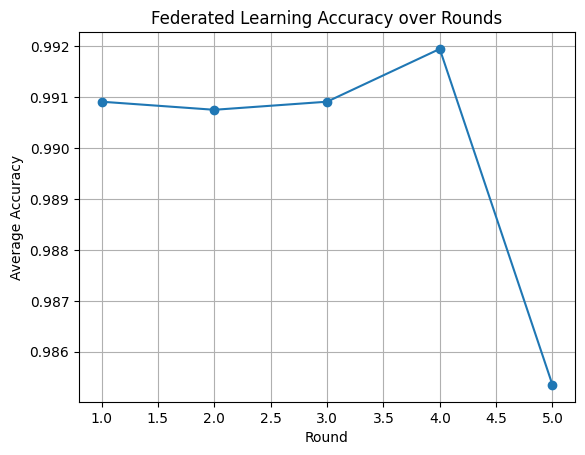

In [8]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
class TorchNodeModel(torch.nn.Module):
    def __init__(self, input_size):
        super(TorchNodeModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 16)
        self.fc2 = torch.nn.Linear(16, 8)
        self.fc3 = torch.nn.Linear(8, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

def evaluate_model(model, val_df):
    label_col = "label" if "label" in val_df.columns else "is_sybil"
    X = torch.tensor(val_df.drop(columns=[label_col, "node_id"]).values, dtype=torch.float32)
    y = torch.tensor(val_df[label_col].astype(float).values, dtype=torch.float32).unsqueeze(1)
    with torch.no_grad():
        pred = model(X)
        pred_binary = (pred > 0.5).float()
        accuracy = (pred_binary == y).float().mean().item()
    return accuracy


def train_node_model(df, input_size):
    label_col = "label" if "label" in df.columns else "is_sybil"
    X = torch.tensor(df.drop(columns=[label_col, "node_id"]).values, dtype=torch.float32)
    y = torch.tensor(df[label_col].astype(float).values, dtype=torch.float32).unsqueeze(1)
    model = TorchNodeModel(input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = torch.nn.BCELoss()
    for epoch in range(10):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
    return model.state_dict()

def average_models(model_dicts):
    avg_model = {}
    for key in model_dicts[0].keys():
        avg_model[key] = sum(model[key] for model in model_dicts) / len(model_dicts)
    return avg_model

def load_node_data(data_dir):
    data = []
    for file in sorted(os.listdir(data_dir)):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(data_dir, file))
            data.append((file, df))
    return data

def run_federated_rounds(data_dir="data_per_node", rounds=5):
    node_data = load_node_data(data_dir)
    label_col = "label" if "label" in node_data[0][1].columns else "is_sybil"
    input_size = node_data[0][1].drop(columns=[label_col, "node_id"]).shape[1]

    global_model = TorchNodeModel(input_size)
    accuracy_log = []

    for rnd in range(rounds):
        local_models = []
        round_accuracies = []

        for fname, df in node_data:
            model_weights = train_node_model(df, input_size)
            local_models.append(model_weights)

            global_model.load_state_dict(model_weights)
            acc = evaluate_model(global_model, df)
            round_accuracies.append(acc)

        avg_model = average_models(local_models)
        global_model.load_state_dict(avg_model)
        torch.save(global_model.state_dict(), f"global_model_round{rnd+1}.pth")

        avg_acc = sum(round_accuracies) / len(round_accuracies)
        accuracy_log.append(avg_acc)
        print(f"[Round {rnd+1}] Avg Accuracy: {avg_acc:.4f}")

    plt.plot(range(1, rounds + 1), accuracy_log, marker='o')
    plt.xlabel("Round")
    plt.ylabel("Average Accuracy")
    plt.title("Federated Learning Accuracy over Rounds")
    plt.grid(True)
    plt.savefig("fl_accuracy_trend.png")
    print("Saved accuracy trend plot as fl_accuracy_trend.png")
    # === Save node reputations based on global model ===
    reputations = {}
    val_df = pd.read_csv("validation_set.csv")

    for fname, df in node_data:
        acc = evaluate_model(global_model, val_df)
        reputations[fname] = {
            "accuracy": round(acc, 4),
            "reputation": round(acc * 10 - 5, 3)
        }

    with open("node_reputations.json", "w") as f:
        json.dump(reputations, f, indent=2)
    print(" Exported node_reputations.json")

if __name__ == "__main__":
    run_federated_rounds()


## Comparison

In [ ]:
with open("node_reputations.json") as f:
    reputations = json.load(f)
y_true = []
y_pred = []
print("\n[Node Reputations]")
print("-" * 40)
for node, info in sorted(reputations.items()):
    rep = info["reputation"]
    acc = info["accuracy"]
    tag = "Sybil?" if "Sybil" in node or rep < 0 else "✅ Honest"
    print(f"{node:25}  Acc: {acc:.3f}  Rep: {rep:.2f}  {tag}")

for node_id, info in reputations.items():
    true_label = 1 if "Sybil" in node_id else 0
    predicted_label = 1 if info["reputation"] < 0 else 0  # threshold

    y_true.append(true_label)
    y_pred.append(predicted_label)

print("\n[Classification Report based on reputation threshold 0]")
print(classification_report(y_true, y_pred, target_names=["Honest", "Sybil"]))


## Step6 Autoencoder anomaly detection

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8), nn.ReLU(), nn.Linear(8, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 8), nn.ReLU(), nn.Linear(8, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train_autoencoder(df, input_size):
    X = torch.tensor(df.values, dtype=torch.float32)
    model = AutoEncoder(input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    for epoch in range(30):
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, X)
        loss.backward()
        optimizer.step()
    return model

def detect_anomalies(model, df, threshold=0.1):
    X = torch.tensor(df.values, dtype=torch.float32)
    recon = model(X)
    mse = ((X - recon)**2).mean(dim=1)
    return (mse > threshold).nonzero(as_tuple=True)[0]

data_dir = "data_per_node"
for fname in sorted(os.listdir(data_dir)):
    if fname.endswith(".csv"):
        print(f"\nProcessing {fname}")
        df = pd.read_csv(os.path.join(data_dir, fname))
        label_col = "label" if "label" in df.columns else "is_sybil"
        X = df.drop(columns=[label_col, "node_id"])
        model = train_autoencoder(X, input_size=X.shape[1])
        anomalies = detect_anomalies(model, X)
        print(f"Anomalies in {fname}: {list(anomalies.numpy())}")


## Step7: Torch Model training

In [ ]:
class TorchNodeModel(nn.Module):
    def __init__(self, input_size):
        super(TorchNodeModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

def train_node_model(path):
    df = pd.read_csv(path)
    label_col = "label" if "label" in df.columns else "is_sybil"
    X = torch.tensor(df.drop(columns=[label_col, "node_id"]).values, dtype=torch.float32)
    y = torch.tensor(df[label_col].astype(float).values, dtype=torch.float32).unsqueeze(1)

    model = TorchNodeModel(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(20):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    return model.state_dict()

# Pick a valid node file to test
test_file = "data_per_node/Node000.csv"

model_weights = train_node_model(test_file)
os.makedirs("FL_model", exist_ok=True)
model_path = os.path.join("FL_model", "global_model.pth")
torch.save(model_weights, model_path)
print(f"[✓] Trained and saved model for {test_file}")


## Step8: Initialize Smart contract

In [ ]:
import json

# ------------------ Smart Contract Simulations ------------------

class FederatedContractSimulator:
    def __init__(self):
        self.model_updates = {}

    def submit_model_update(self, node_id, accuracy):
        self.model_updates[node_id] = accuracy
        print(f"[+] {node_id} submitted model accuracy = {accuracy:.3f}")

    def aggregate(self):
        if not self.model_updates:
            print("[!] No model updates submitted")
            return None
        avg = sum(self.model_updates.values()) / len(self.model_updates)
        print(f"[*] Aggregated model accuracy: {avg:.3f}")
        return avg

class ReputationContractSimulator:
    def __init__(self, reputations):
        self.reputation_scores = reputations

    def flag_suspicious_nodes(self, threshold=1.0):
        flagged = [
            node_id for node_id, record in self.reputation_scores.items()
            if record['reputation'] < threshold
        ]
        print(f"[!] Flagged nodes below threshold {threshold}: {flagged}")
        return flagged

# ------------------ Load Data ------------------

with open("node_reputations.json") as f:
    reputations = json.load(f)

# ------------------ Reputation Filtering ------------------

rep_contract = ReputationContractSimulator(reputations)
flagged_nodes = rep_contract.flag_suspicious_nodes(threshold=2.5)

# ------------------ Federated Model Aggregation ------------------

fl_contract = FederatedContractSimulator()
for node_id, rec in reputations.items():
    fl_contract.submit_model_update(node_id, rec["accuracy"])  # Use actual accuracy
fl_contract.aggregate()


## Comparison of Local VS Global fl training

In [ ]:
class TorchNodeModel(nn.Module):
    def __init__(self, input_size):
        super(TorchNodeModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

def load_and_prepare_data(path):
    df = pd.read_csv(path)
    label_col = "label" if "label" in df.columns else "is_sybil"
    X = torch.tensor(df.drop(columns=[label_col, "node_id"]).values, dtype=torch.float32)
    y = torch.tensor(df[label_col].astype(float).values, dtype=torch.float32).unsqueeze(1)
    return X, y, df[label_col].astype(int).values, df

def predict_and_evaluate(model, X, y_true):
    model.eval()
    with torch.no_grad():
        y_pred = (model(X) > 0.5).int().numpy()
    labels = [0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    report = classification_report(y_true, y_pred, labels=labels, output_dict=True)
    return report, cm, y_pred

# Automatically pick a Sybil node
data_dir = "data_per_node"
sybil_file = None

for fname in os.listdir(data_dir):
    if not fname.endswith(".csv"):
        continue
    df_check = pd.read_csv(os.path.join(data_dir, fname))
    label_col = "label" if "label" in df_check.columns else "is_sybil"
    if df_check[label_col].astype(int).sum() > 0:  # has at least one Sybil label
        sybil_file = fname
        break

if sybil_file is None:
    print("❌ No Sybil-labeled node found.")
    exit()

print(f"[✓] Found Sybil-labeled node: {sybil_file}")
file_path = os.path.join(data_dir, sybil_file)
X, y, y_true, df_meta = load_and_prepare_data(file_path)
input_size = X.shape[1]

# Load local model
local_model = TorchNodeModel(input_size)
local_model.load_state_dict(torch.load("global_model.pth"))
local_report, local_cm, _ = predict_and_evaluate(local_model, X, y_true)

# Load global model
global_model = TorchNodeModel(input_size)
global_model.load_state_dict(torch.load("global_model_round5.pth"))
global_report, global_cm, _ = predict_and_evaluate(global_model, X, y_true)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp1 = ConfusionMatrixDisplay(confusion_matrix=local_cm, display_labels=["Honest", "Sybil"])
disp1.plot(ax=axes[0], values_format="d", cmap="Blues", colorbar=False)
axes[0].set_title(f"Local Model on {sybil_file}")

disp2 = ConfusionMatrixDisplay(confusion_matrix=global_cm, display_labels=["Honest", "Sybil"])
disp2.plot(ax=axes[1], values_format="d", cmap="Blues", colorbar=False)
axes[1].set_title(f"Global Model on {sybil_file}")

plt.tight_layout()
plt.savefig("sybil_node_comparison.png")
print(" Saved confusion matrix: sybil_node_comparison.png")


## Plot reputation Histogram

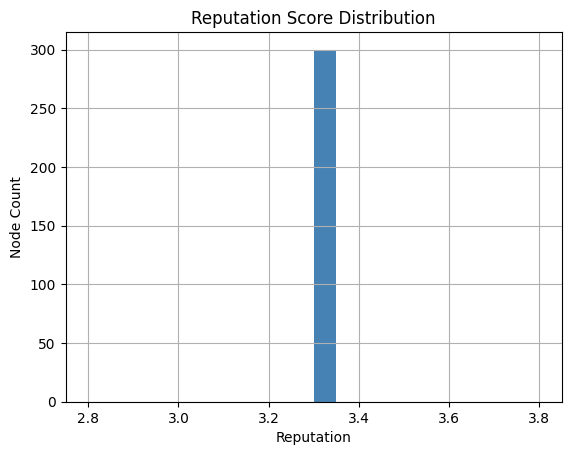

In [15]:
import json
import matplotlib.pyplot as plt

with open("node_reputations.json") as f:
    rep = json.load(f)

values = [v["reputation"] for v in rep.values()]
plt.hist(values, bins=20, color="steelblue")
plt.title("Reputation Score Distribution")
plt.xlabel("Reputation")
plt.ylabel("Node Count")
plt.grid(True)
plt.show()
